# MODULO - Tutorial 4
## Decomposition on non-cartesian grids

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt 

FOLDER = './ex_4_dataJet/'

with open(FOLDER + 'dataJet', 'rb') as f:
    Dat = pickle.load(f)

data = Dat['U']
grid = Dat['grid']

with open(FOLDER + 'timeJet', 'rb') as f:
    time = pickle.load(f)

Let's inspect the dataset ...

(53129, 2)


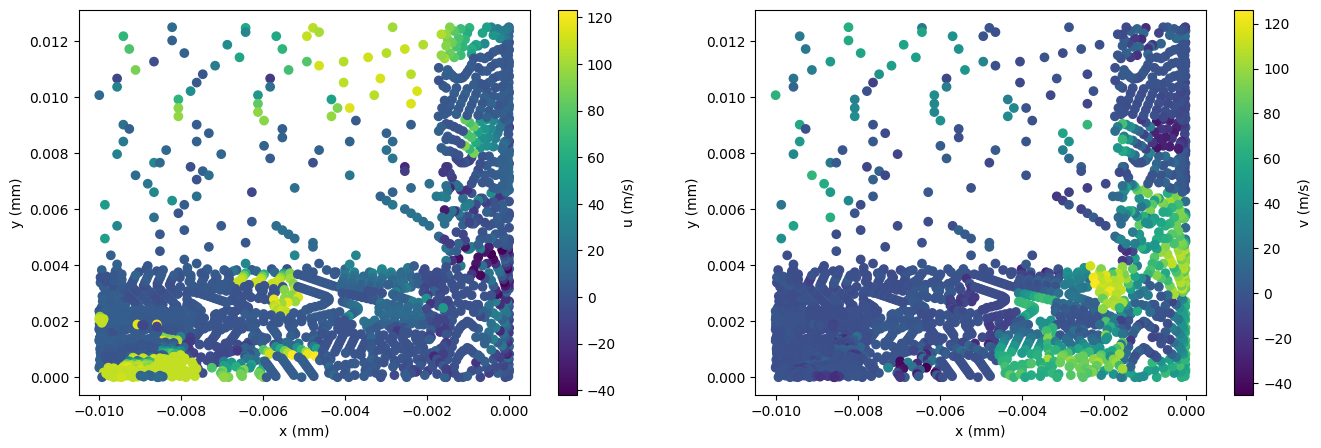

In [2]:
U_0 = np.array(data[1]).reshape(-1, 2)
print(U_0.shape)
x, y = grid[:, 0], grid[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
sca = axs[0].scatter(x[::25], y[::25], c=U_0[::25, 0])
cb = plt.colorbar(sca)
cb.set_label('u (m/s)')
axs[0].set(xlabel='x (mm)', ylabel='y (mm)')

sca = axs[1].scatter(x[::25], y[::25], c=U_0[::25, 1])
cb = plt.colorbar(sca)
cb.set_label('v (m/s)')
axs[1].set(xlabel='x (mm)', ylabel='y (mm)')
plt.show()


Re-sample data set with a fixed time step

In [3]:
dts, counts= np.unique(np.diff(time), return_counts=True)
dt = dts[2]

indexes = np.where(np.diff(time) == dt)[0]

U_resampled = np.asarray(data)[indexes]

In [6]:
U_resampled.shape

(2953, 53129, 2)

In [22]:
xx = np.unique(grid[:, 0])
yy = np.unique(grid[:, 1])

X, Y = np.meshgrid(xx, yy)

grid[:, 0]

array([-0.00999  , -0.01     , -0.01     , ..., -0.0017185, -0.001724 ,
       -0.0017185], dtype=float16)

In [49]:
tt = U_resampled.shape[0]
print(tt*dt)

0.14764999999998374
2953


IAssemble dataset for MODULO

In [59]:
N_S = grid.shape[0] # Number of mesh points
N = 2
tt = U_resampled.shape[0]

D = np.zeros((N_S * N, tt))

for i in range(tt):
    tmp = np.array(U_resampled[i])
    d_i = np.concatenate([tmp[:, 0], tmp[:, 1]], axis=0)
    D[:, i] = d_i
    
# Mean removal by columns (i.e. by time)
D_ = D - np.mean(D, axis=1).reshape(-1, 1)

In [60]:
from modulo_vki.modulo.modulo import MODULO

m = MODULO(data=D_, is_cartesian=(False, (x, y)), n_Modes=5, dtype='float64')

Phi_POD, Psi_POD, Sigma_POD = m.compute_POD_K()

MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform Multiscale Modal Analysis of numerical and experimental data. 



 Computing Temporal correlation matrix K ...

 Done.
Saving POD temporal basis
Completing Spatial Structures Modes: 


100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


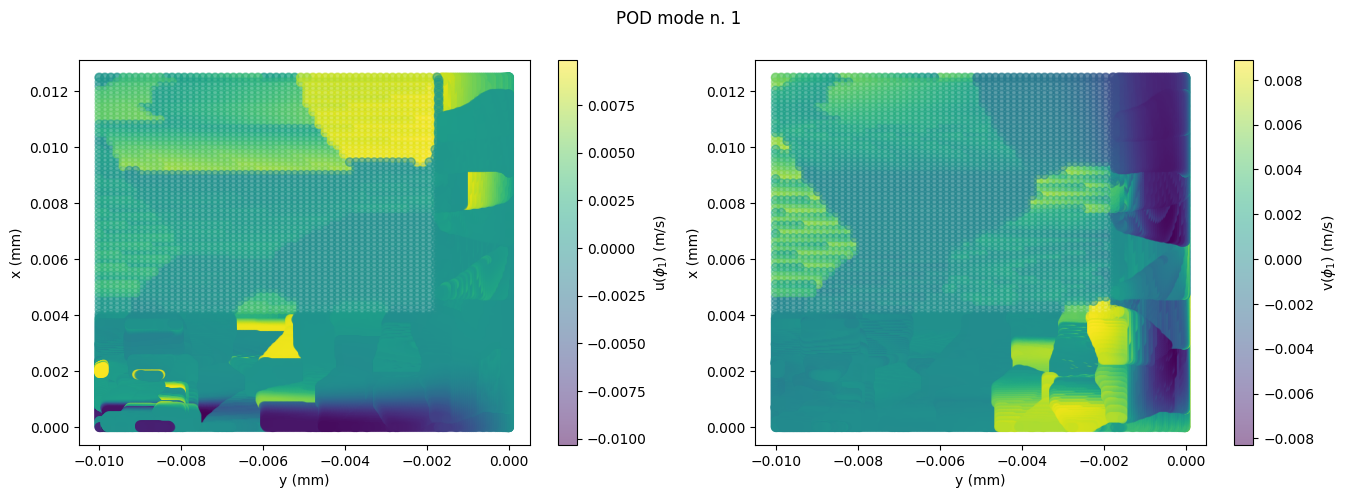

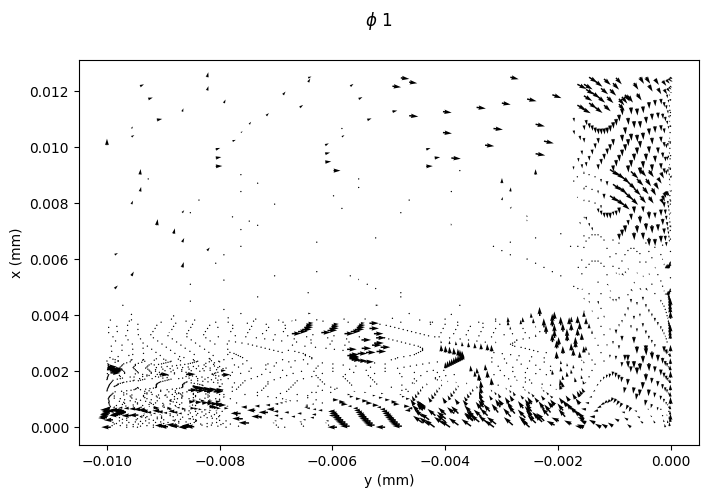

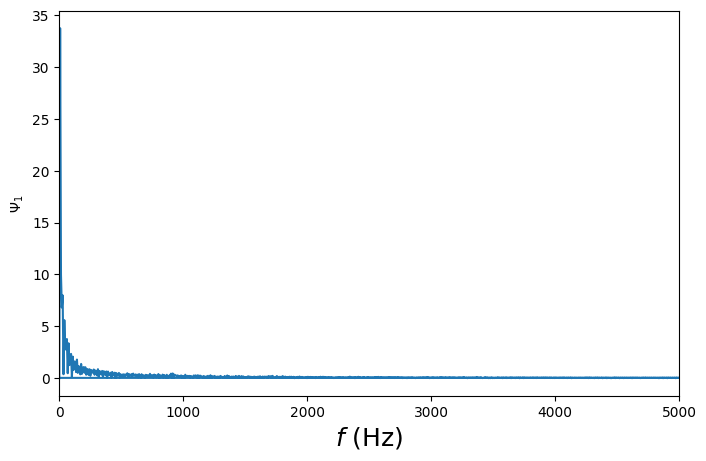

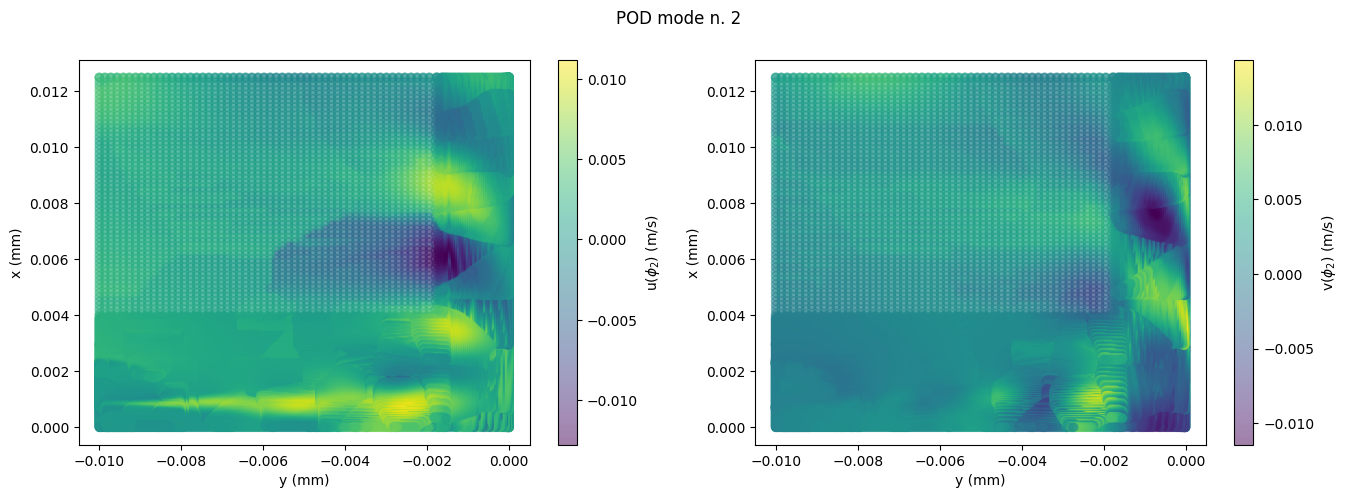

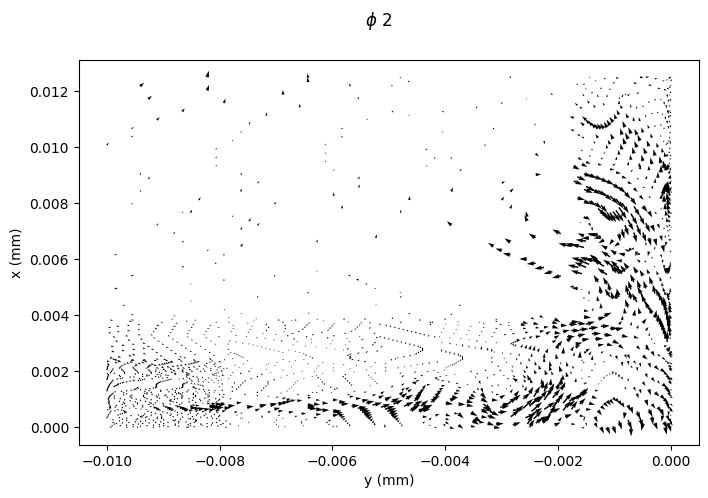

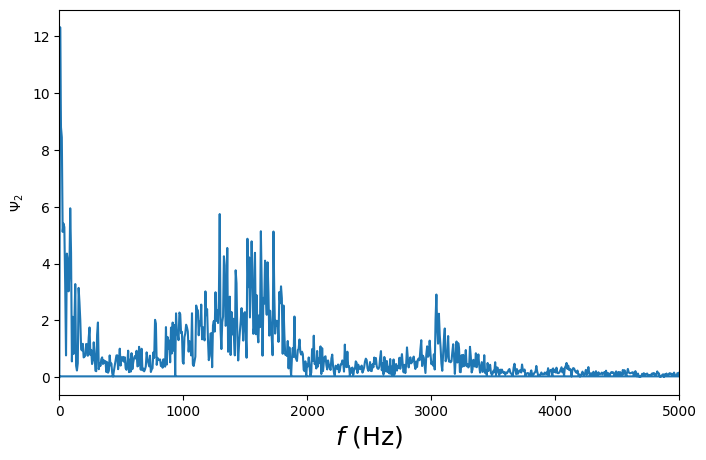

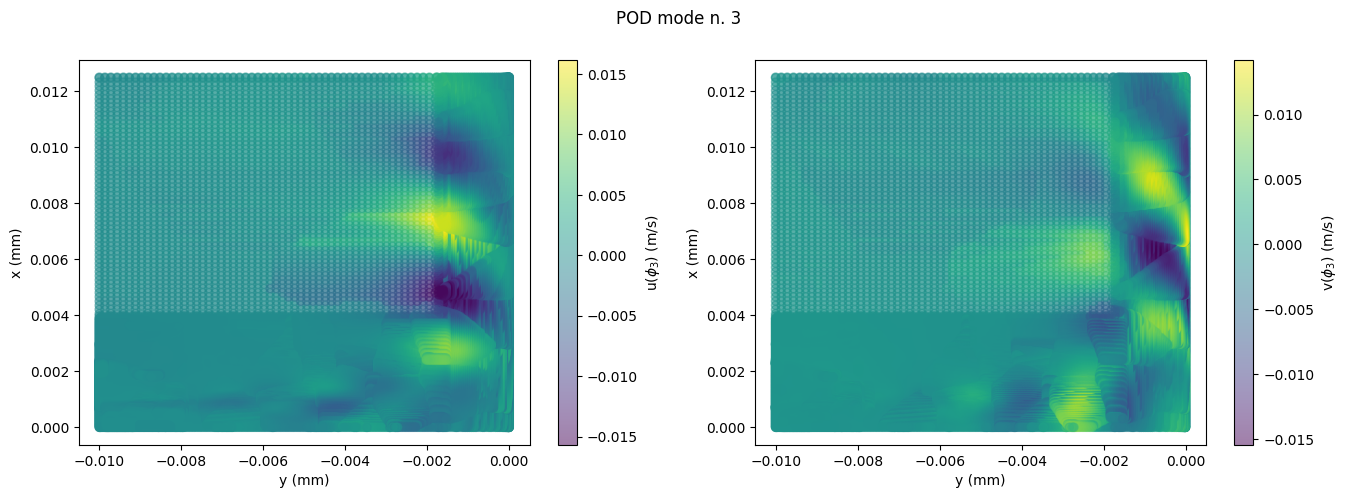

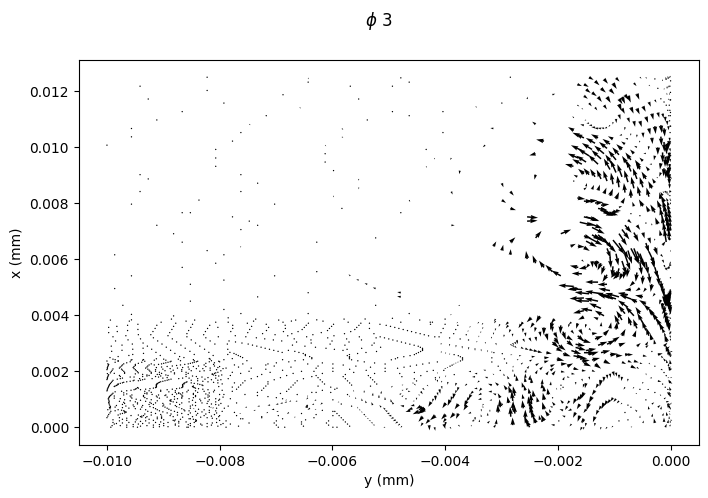

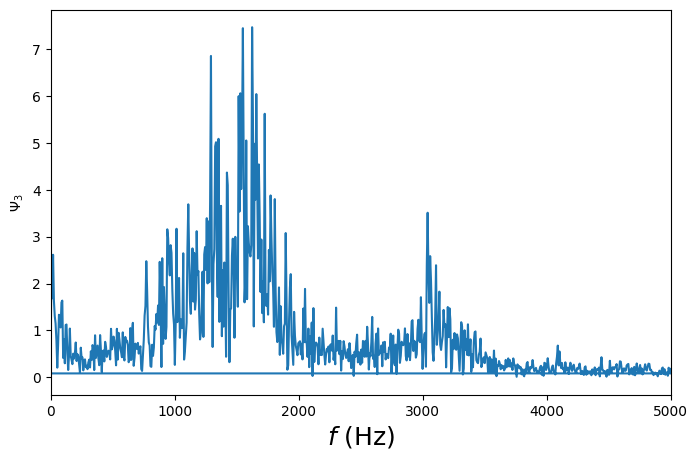

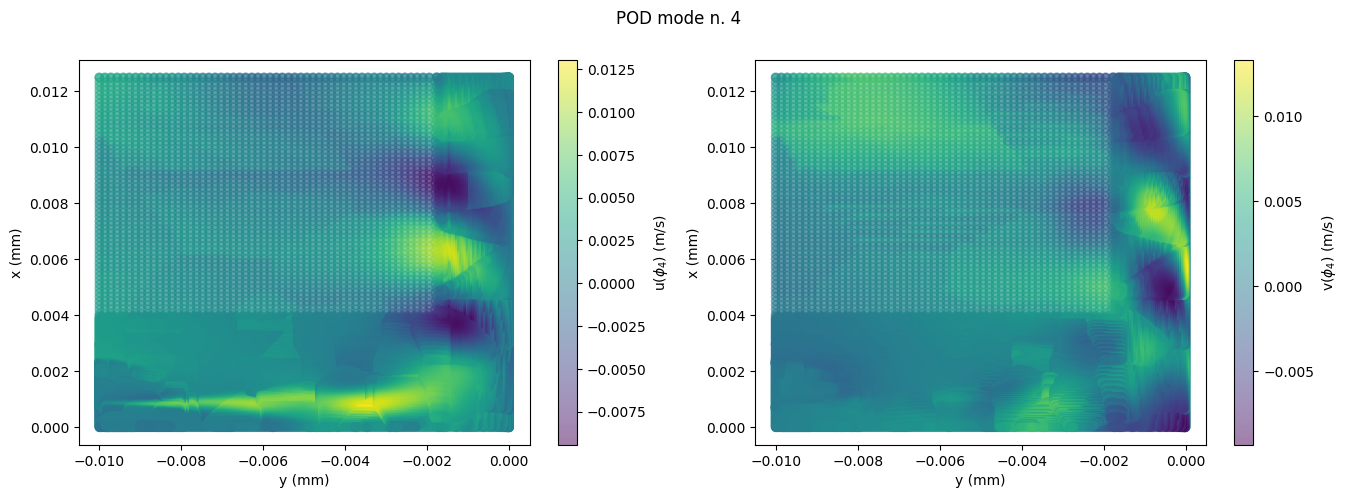

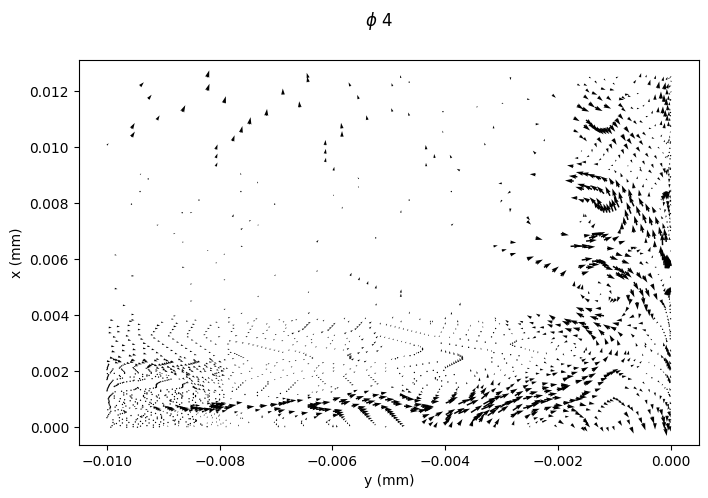

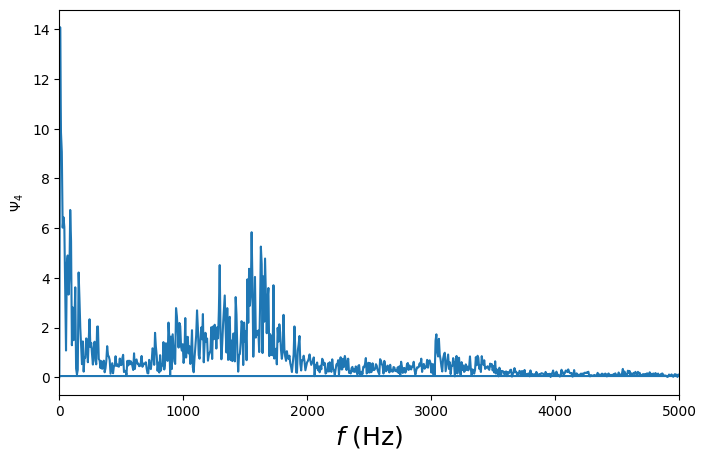

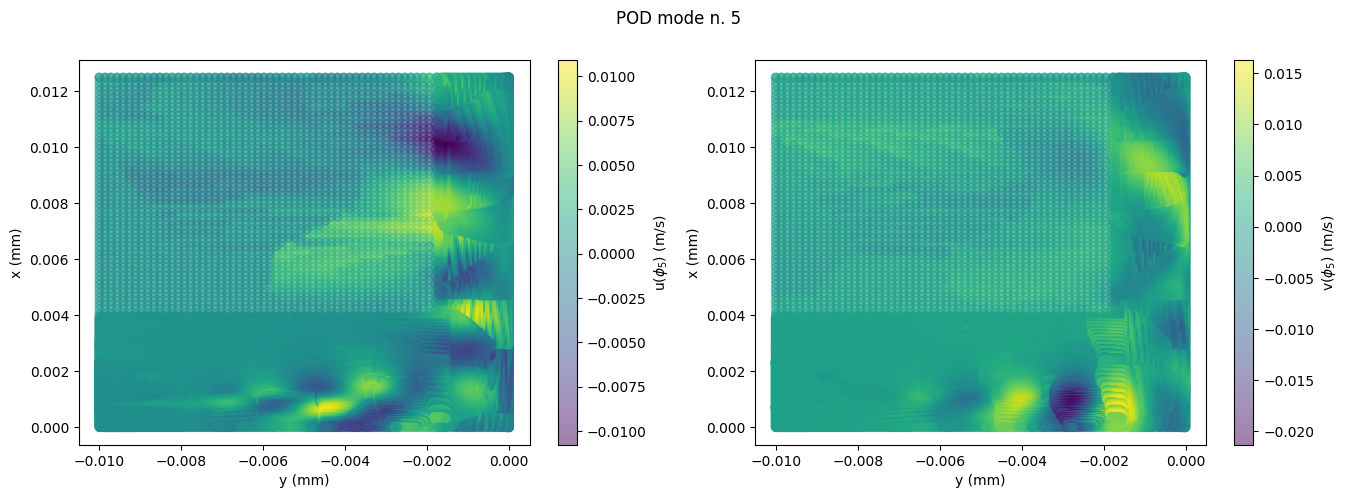

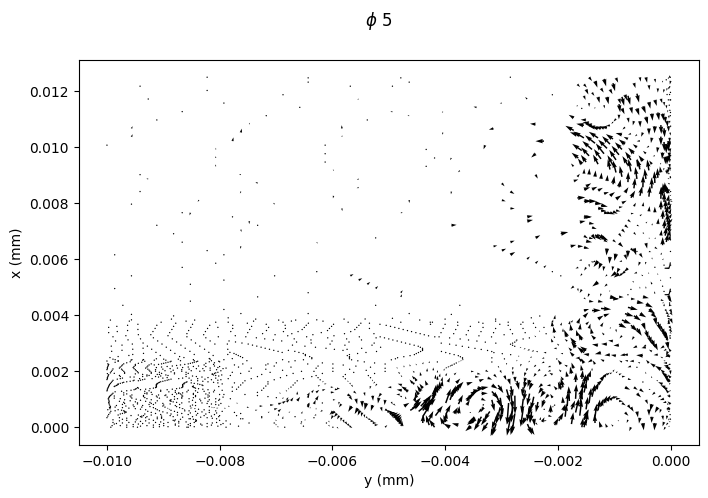

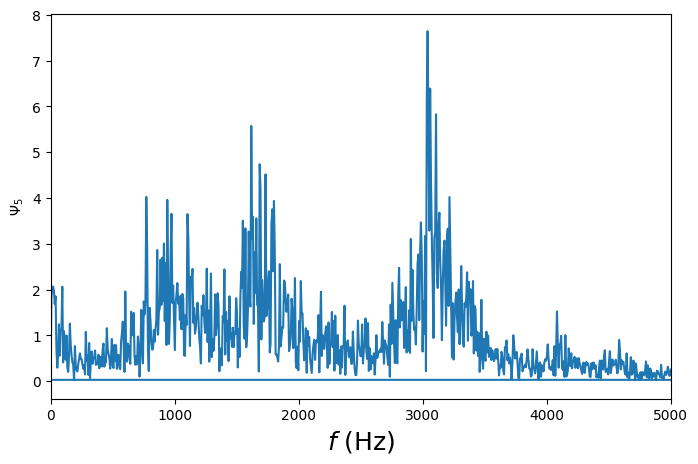

In [65]:

nxny=int(len(Phi_POD[:,0])/2)

U_D=np.real(Phi_POD)
U_D.shape

STEPx = 10
STEPy = 10

n_x, n_y = np.shape(grid)
# U_g=U_D[:nxny, 0]
# V_g=U_D[nxny:, 0]

for k in range(5):
    U_g=U_D[:nxny, k]
    V_g=U_D[nxny:, k]

    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle('POD mode n. {}'.format(k + 1))
    sca1 = axs[0].scatter(x, y, c=U_g)
    cb = plt.colorbar(sca1)
    cb.set_label('u($\phi_{}$) (m/s)'.format(k + 1))
    axs[0].set(xlabel='y (mm)', ylabel='x (mm)')

    sca2 = axs[1].scatter(x, y, c=V_g)
    cb2 = plt.colorbar(sca2)
    cb2.set_label('v($\phi_{}$) (m/s)'.format(k + 1))
    axs[1].set(xlabel='y (mm)', ylabel='x (mm)')
    # plt.savefig('./phi_{}.png'.format(k + 1), dpi=500)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.suptitle('$\phi$ {}'.format(k + 1))
    ax.quiver(x[::25], y[::25], U_g[::25], V_g[::25], color='k', scale=0.6)
    ax.set_xlabel('y (mm)')
    ax.set_ylabel('x (mm)')
    # plt.savefig('./phi_{}_quiver.png'.format(k+1), dpi=500)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    Signal = Psi_POD[:, k]
    s_h = np.abs((np.fft.fft(Signal - Signal.mean())))
    Freqs = np.fft.fftfreq(tt) / dt
    ax.plot(Freqs, s_h, '-', linewidth=1.5) #* 0.001 / 100
    ax.set_xlim(-0.001, 5000)
    ax.set_xlabel('$f$ (Hz)', fontsize=18)
    ax.set_ylabel('$\Psi_{}$'.format(k+1))
    # plt.savefig('./psi_{}.png'.format(k + 1), dpi=500)
    plt.show()